In [1]:
import numpy as np
import pandas as pd
from astropy.io import fits
from multiprocessing import  Pool
from astropy.io import ascii
from glob import glob
from astropy.table import Table
import matplotlib.pyplot as plt
%matplotlib inline
import os
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output
from time import sleep
# Import
from pandarallel import pandarallel
# Initialization
pandarallel.initialize(nb_workers=6)

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
all_stars = Table.read('../HST_Guido/30dor_all_newerr.UBVIHa.rot', format='ascii').to_pandas()
all_stars.columns = 'ID;x;y;RA;Dec;u_1;eu_2;b_1;eb_2;v_1;ev_2;i_1;ei_2;ha_1;eha_2'.split(';')
all_stars = all_stars.set_index('ID')
all_stars = all_stars[(all_stars['ha_1']>5)&(all_stars['ha_1']<50)]
all_stars = all_stars[(all_stars['v_1']>5)&(all_stars['v_1']<50)]
all_stars = all_stars[(all_stars['i_1']>5)&(all_stars['i_1']<50)]
all_stars = all_stars[(all_stars['eha_2']>0)&(all_stars['eha_2']<50)]

In [3]:
red_giants = ascii.read('../HST_Guido/redgiants_coords.txt').to_pandas()
red_giants = all_stars.loc[red_giants.ID]

/home/luuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  


In [4]:
pms = ascii.read('../HST_Guido/30dorallpmsstars.txt').to_pandas()
distances = np.sqrt((pms.X.values - all_stars.x.values[:,np.newaxis])**2+(pms.Y.values - all_stars.y.values[:,np.newaxis])**2).T
argmins  = np.argmin(distances, axis=1)
mindists = np.min(distances, axis=1)
argmins = argmins[mindists<1]
pms_stars = all_stars.iloc[argmins]

In [5]:
distances = np.sqrt((pms.X.values - all_stars.x.values[:,np.newaxis])**2+(pms.Y.values - all_stars.y.values[:,np.newaxis])**2).T
distances = pd.DataFrame(distances, index=pms.index, columns = all_stars.index)
pms_id_argmins  = distances.idxmin(axis=0)#np.argmin(distances, axis=0)
mindists = distances.min(axis=0)#np.min(distances, axis=0)
#argmins = argmins[mindists<1.5
argmins = np.argmin(distances.values, axis=0)[mindists<1]
pms_id_argmins = pms_id_argmins[mindists<1]
pms = pms.iloc[argmins]
pms['AssocID'] = pms_id_argmins.index
pms = pms.set_index('AssocID').drop('NR', axis=1)
pms

,X,Y,V,eV,I,eI,Ha,eHa,LgT,eLgT,LgL,eLgL,LgHa,EW,Mass,Age,LgMdot
AssocID,,,,,,,,,,,,,,,,,
39,1515.66,778.65,11.82,0.01,11.58,0.01,10.84,0.01,3.90,0.03,4.60,0.06,1.68,-16.1,0.0,0.0,9.99
151,3799.66,4212.51,13.63,0.01,13.80,0.01,13.03,0.00,4.17,0.16,4.34,0.17,0.74,-11.9,4.9,0.5,-4.27
181,3242.22,2950.02,13.73,0.01,13.69,0.01,12.30,0.00,3.96,0.04,3.87,0.07,1.25,-43.0,0.0,0.0,9.99
202,3569.54,2491.61,13.27,0.02,13.73,0.03,11.75,0.00,4.54,3.73,5.30,3.73,1.51,-61.9,3.4,0.4,-3.62
325,3780.93,2483.78,14.25,0.00,13.86,0.00,11.25,0.00,3.86,0.03,3.64,0.07,1.77,-169.6,0.0,0.0,9.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21141,1945.35,379.54,23.80,0.06,22.54,0.03,21.32,0.17,3.66,0.02,0.03,0.06,-2.35,-46.1,1.0,3.0,-7.81
21268,2405.28,2920.34,24.33,0.07,22.97,0.02,20.59,0.14,3.64,0.02,-0.13,0.06,-1.97,-172.1,0.9,3.7,-7.43
21291,2896.09,1965.39,23.99,0.06,22.80,0.03,19.60,0.11,3.67,0.02,-0.07,0.06,-1.55,-371.2,1.0,5.1,-7.10


In [43]:
phot_df = pd.read_pickle('IRAF_output.pickle').drop('ID', axis=1).reset_index()
phot_df['MAG'] = phot_df['MAG'] - 0.1
phot_df.rename({'ID': 'AssocID'}, axis=1, inplace=True)

In [ ]:
phot_df = phot_df[['AssocID', 'Filter', 'T_Start', 'Exp_Length', 'AREA', 'CERROR', 'CIER','FLUX', 
                   'IMAGE', 'ITIME', 'MAG', 'MERR',
                   'MSKY', 'NSKY', 'NSREJ', 'OTIME', 'RAPERT', 'XCENTER','YCENTER']]
phot_df = phot_df.set_index(['AssocID', 'Filter', 'T_Start']).sort_index()

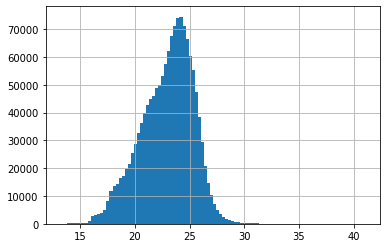

In [46]:
phot_df['MAG'].hist(bins=100)

In [ ]:
phot_df = phot_df[~phot_df['MAG'].isna()]
phot_df = phot_df[~phot_df['MERR'].isna()]
phot_df = phot_df[phot_df['MAG']<30]
phot_df = phot_df[phot_df['MERR']<0.2]

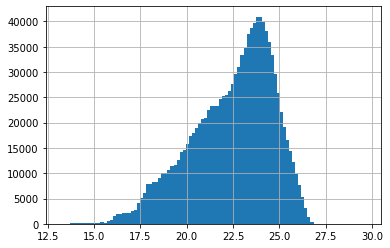

In [111]:
phot_df = phot_df[phot_df.groupby(['AssocID', 'Filter'])['MAG'].count() >= 3]

/home/luuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [49]:
phot_df = pd.merge(phot_df, all_stars[['RA', 'Dec']], left_on='AssocID', right_index=True)

/home/luuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


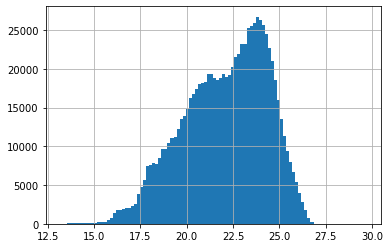

In [50]:
phot_df['MAG'].hist(bins=100)

In [8]:
def robust_mean(mags, synerrs):
    mags = mags.values
    synerrs = synerrs.values
    synerrs = synerrs[np.argsort(mags)]
    mags = np.sort(mags)
    if len(mags)>5:
        to_drop = (len(mags)//6)
        mags = mags[to_drop:-to_drop]
        synerrs = synerrs[to_drop:-to_drop]
    weighted_mean = np.nansum(1/synerrs**2 * mags) / np.nansum(1/synerrs**2)
    return weighted_mean, np.sqrt(np.mean(np.power(mags-weighted_mean,2)))


def get_mean_sigmaprime(phot_df):
    """This will take some time"""
    StarIDs = phot_df.index.get_level_values(0).unique().values
    phot_df['RobustMean'] = 0
    phot_df['RobustSigma'] = 0
    i=0
    for StarID in StarIDs:
        filters = phot_df.loc[StarID].index.get_level_values(0).unique().values
        print(filters)
        for this_filter in filters:
            sub_phot_df = phot_df.loc[StarID,this_filter]
            Lightcurve_SynErrors = sub_phot_df.MERR
            Lightcurve_mags = sub_phot_df.MAG
            TrueMag, SigmaPrime = np.median(Lightcurve_mags), np.std(Lightcurve_mags)#robust_mean(Lightcurve_mags, Lightcurve_SynErrors)
            phot_df.loc[(StarID, this_filter,),'RobustMean'] = TrueMag
            phot_df.loc[(StarID, this_filter,),'RobustSigma']= SigmaPrime
    phot_df['SigmaPrimeDeviation'] = (phot_df['MAG'] - phot_df['RobustMean']).abs() / phot_df['RobustSigma']
    phot_df['High_sigma_prime'] = phot_df['SigmaPrimeDeviation'] > 4
    return phot_df
#phot_df = get_mean_sigmaprime(phot_df)

In [76]:
def nearest_neighbours(phot_df, Nstars = 80):
    catalogue = phot_df.groupby('AssocID')['RA', 'Dec'].median()
    Nentries = len(catalogue)
    
    deltaRA  = np.memmap('deltaRA.temp' , dtype='float64', mode='w+', shape=(Nentries,Nentries))
    deltaDEC = np.memmap('deltaDec.temp', dtype='float64', mode='w+', shape=(Nentries,Nentries))
    
    deltaRA[:]  = catalogue.RA.values - catalogue.RA.values[:,np.newaxis]
    deltaDEC[:] = catalogue.Dec.values - catalogue.Dec.values[:,np.newaxis]
    
    deltaAngle = deltaRA**2 + deltaDEC**2
    del deltaRA, deltaDEC
    
    nearest = catalogue.index.values[np.argsort(deltaAngle, axis=1)] # To correct for ID <-> argument
    nearest = pd.DataFrame(nearest[:,1:Nstars+1], index=catalogue.index)
    return nearest

def get_local_mzp_corr(phot_df):
    phot_df['MagDiff'] = phot_df['MAG'] - phot_df.groupby(['AssocID', 'Filter'])['MAG'].median()#['RobustMean']

    IDs = phot_df.index.get_level_values(0).unique()
    phot_df['MZPCorr']=0
    for ID in IDs:
        neightbours = nearest.loc[ID]
        neightbour_photometry = phot_df.loc[neightbours.values]
        photometry = neightbour_photometry[neightbour_photometry.MAG<23]
        if photometry.index.get_level_values(0).nunique()<20:
            photometry = neightbour_photometry
        photometry = neightbour_photometry.sort_values(by='MAG')
        MagOffset = photometry.groupby(['Filter', 'T_Start'])['MagDiff'].median()
        MagOffset = pd.DataFrame(MagOffset)
        MagOffset.columns = ['MZPCorr2']
        phot_df.loc[ID,'MZPCorr'] = pd.DataFrame(phot_df.loc[ID]).join(MagOffset)['MZPCorr2'].values
    phot_df['MAG_ORIG'] = phot_df['MAG']
    phot_df['MAG'] = phot_df['MAG'] - phot_df['MZPCorr']
    return phot_df
nearest = nearest_neighbours(phot_df)
#phot_df = get_local_mzp_corr(phot_df)
phot_df=get_local_mzp_corr(phot_df)

In [112]:
phot_df.to_pickle('cleaned_phot_df.pickle')

In [113]:
class Analysis():
    def __init__(self, phot_df):
        self.ApplySelection(phot_df)
        return

    def ApplySelection(self, phot_df):
        self.phot_df = phot_df#[phot_df.SynErrorDevSig<=20]
        self.phot_df = self.phot_df[self.phot_df.Exp_Length=='deep']
    
    def GetMADvalues(self):
        phot_df          = self.phot_df
        MedianMagTime    = phot_df.groupby(['AssocID', 'Filter', 'T_Start'])['MAG'].median()
        MedianMagOverall = phot_df.groupby(['AssocID', 'Filter'])['MAG'].median()
        MagOffset        = (MedianMagTime - MedianMagOverall).abs()
        self.MAD         = MagOffset.groupby(['AssocID', 'Filter']).median()
        return self.MAD
    
    def GetMinMaxvalues(self):
        phot_df          = self.phot_df
        MaxMagnitude     = phot_df.groupby(['AssocID', 'Filter'])['MAG'].max()
        MinMagnitude     = phot_df.groupby(['AssocID', 'Filter'])['MAG'].min()
        MinMagMagnitude  = (MaxMagnitude - MinMagnitude).abs()
        self.MinMag      = MinMagMagnitude.groupby(['AssocID', 'Filter']).median()
        return self.MinMag
    
    def GetMedMags(self):
        self.MedMag = self.phot_df.groupby(['AssocID', 'Filter'])['MAG'].median()
        return self.MedMag

    def GetMedMagErr(self):
        self.MedMagErr = self.phot_df.groupby(['AssocID', 'Filter'])['MERR'].median()
        return self.MedMagErr

    
    def GetMADPlot(self, filter_=None):
        self.GetMADvalues()
        self.MAD.hist(bins=np.arange(0,1,0.002),cumulative=False, histtype='step', normed=False, linewidth=2)
        plt.xlabel('MAD Value')
        plt.ylabel('PDF')
        plt.show()
        
        self.MAD.hist(bins=np.arange(0,1,0.002),cumulative=True, histtype='step', normed=True, linewidth=2)
        plt.xlabel('MAD Value')
        plt.ylabel('CDF')
        plt.show()
        
        self.GetMedMags()
        if filter_ !=None:
            med_mags = self.MedMag[self.MedMag.index.get_level_values(1)==filter_]
            mad_vals = self.MAD[self.MAD.index.get_level_values(1)==filter_]
        else:
            med_mags = self.MedMag#[self.MedMag.index.get_level_values(1)==filter_]
            mad_vals = self.MAD#[self.MAD.index.get_level_values(1)==filter_]
        plt.hist2d(med_mags, mad_vals, bins=(np.linspace(15,28,80), np.linspace(0,0.4,50)), cmap=plt.cm.jet)
        plt.xlabel('Median magnitude')
        plt.ylabel('MAG Value')
        plt.show()
        
    
    def DrawTrumpets(self,magcol = 'MAG', IDcol = 'AssocID'):
        phot_df = self.phot_df
        merrcol = magcol.replace('MAG', 'MERR')
        # Trumpet plot
        from matplotlib.colors import LogNorm
        magnitudes = phot_df[magcol]
        filters = magnitudes.index.get_level_values(1).unique()
        plt.figure(figsize=(20,10))
        num=0
        for filter_ in np.sort(filters):
            epochs  = magnitudes.loc[:,filter_,:].index.get_level_values(1).unique()
            mags_t0 = pd.DataFrame(magnitudes.loc[:, filter_, epochs[0], :])
            num+=1
            plt.subplot('23'+str(num))
            xs, ys = np.array([]), np.array([])
            for i in range(len(epochs)-1):
                mags_t1 = pd.DataFrame(magnitudes.loc[:, filter_, epochs[i+1], :])
                join_mags = mags_t0.join(mags_t1, lsuffix = '_t0', rsuffix='_t1', how='inner')
                join_mags['DeltaMag'] = join_mags[magcol+'_t1'] - join_mags[magcol+'_t0']
                median_mags = magnitudes.loc[:, filter_, :].groupby([IDcol]).median()
                join_mags = join_mags.join(median_mags)
                x, y = join_mags[magcol].values, join_mags['DeltaMag'].values
                x, y = x[np.isfinite(x)*np.isfinite(y)], y[np.isfinite(x)*np.isfinite(y)]
                xs = np.hstack((xs,x))
                ys = np.hstack((ys,y))
            plt.hist2d(xs, ys, bins=(np.linspace(15,28,80), np.linspace(-3,3,150)), cmap='jet', cmin=1)
            plt.title(filter_, pad=-15)
            plt.ylabel('Delta Mag')
            plt.xlabel('Median magnitude')
            plt.ylim(-1,1)
            plt.xlim(14,27)
            if num in [1,4,7]:
                plt.ylabel('Delta Mag')
            else:
                plt.yticks([])
            if num in [4,5]:
                plt.xlabel('Median magnitude')
            else:
                plt.xticks([])
            plt.ylim(-1.5,1.5)
        plt.tight_layout()
        #plt.savefig('trumpet_diagrams.png', dpi=500)
        plt.show()

    def MAG_pdf(self, magcol = 'MAG',fluxcol='FLUX_APER2', IDcol = 'AssocID'):
        phot_df = self.phot_df
        fig, ax = plt.subplots(figsize=(10,6))
        for name, group in phot_df[phot_df[fluxcol]>0].groupby('Filter')[magcol]:
            group.hist(bins=np.arange(15,30,0.1), histtype='step', ax=ax, normed=True, label=name, linewidth=2)
        ax.legend()
        ax.set_xlabel('Magnitude')
        ax.set_ylabel('Normalized frequency')
        ax.set_xlim(15,30)
        plt.show()


        fig, ax = plt.subplots(figsize=(10,6))
        for name, group in phot_df[phot_df[fluxcol]>0].groupby('Filter')[magcol]:
            group.hist(bins=np.arange(15,30,0.1),cumulative=True, histtype='step', ax=ax, normed=True, label=name, linewidth=2)
        ax.legend()
        ax.set_xlabel('Magnitude')
        ax.set_ylabel('Normalized frequency')
        ax.set_xlim(15,30)
        plt.show()
    
    def GetNumberOfMeasurements(self):
        counts = self.phot_df['MAG'].groupby(['AssocID', 'Filter']).count()
        return counts
    
    def GetTimeSeries(self, AssocID = None, Filter=None):
        if not AssocID:
            MinMeasurements = 10
            WhichEntries    = self.GetNumberOfMeasurements()>MinMeasurements
            WhichEntries    = WhichEntries[WhichEntries]
            RandomRow       = np.random.randint(0,len(WhichEntries))
            AssocID         = WhichEntries.index.get_level_values(0)[RandomRow]
            Filter          = WhichEntries.index.get_level_values(1)[RandomRow]
        JulianDates = self.phot_df.loc[AssocID, Filter].reset_index().T_Start
        Magnitudes  = self.phot_df.loc[AssocID, Filter].MAG
        #Synth_err   = self.phot_df.loc[AssocID, Filter].SynErrorDevSig
        MAG_err     = self.phot_df.loc[AssocID, Filter].MERR
        
        plt.figure(figsize=(8,5))
        plt.title('AssocID ' +str(AssocID) + ' ' +Filter + ' mag ' +np.round(self.phot_df.loc[AssocID, Filter]['MAG'].median(),3).astype(str))
        plt.errorbar(JulianDates, Magnitudes, yerr=MAG_err, linestyle='none', fmt='o', ecolor='black', capthick=2)
        #plt.scatter(JulianDates, Magnitudes, marker='o', c='black')
        return JulianDates.values, Magnitudes.values, MAG_err.values
        plt.show()
        

    def median_mad_sigma(self):
        mags, mads = self.GetMedMags(), self.GetMADvalues()  
        mags = pd.DataFrame(mags)
        mags.columns = ['MAG']
        mads = pd.DataFrame(mads)
        mads.columns = ['MAD']
        # Drop first 0.5 mag and last 0.5 mag
        lower_thres = pd.DataFrame(mags.groupby('Filter').min()+0.5)#FilterMags.min()+0.5
        lower_thres.columns = ['LowerMagThresh']
        upper_thres = pd.DataFrame(mags.groupby('Filter').max()-0.5)##FilterMags.max()-0.5
        upper_thres.columns = ['UpperMagThresh']

        mags = pd.merge(mags, lower_thres, left_index=True,left_on='Filter', right_index=True)#, right_on='Filter')
        mags = pd.merge(mags, upper_thres, left_index=True,left_on='Filter', right_index=True)

        mags = mags[(mags.MAG>mags.LowerMagThresh)*(mags.MAG<mags.UpperMagThresh)]
        MagsMads = mags.copy()
        MagsMads = MagsMads.join(mads)

        MagsMads['MagBin'] = pd.cut(MagsMads['MAG'], bins=20)
        MedMadBin = pd.DataFrame(MagsMads.groupby('MagBin')['MAD'].median())
        MedMadBin.columns = ['MedMadBin']
        MagsMads = pd.merge(MagsMads,MedMadBin, left_on='MagBin', right_index=True)

        MagsMads['MADSigma'] = MagsMads['MAD'] / MagsMads['MedMadBin']
        return MagsMads
    
    def potential_candidates(self):
        MagsMads = self.median_mad_sigma()
        PotCandidates = MagsMads['MAD'].unstack()
        PotCandidates['NFilters'] = PotCandidates.count(axis=1)
        return PotCandidates
    
    def inspect(self,AssocID, Filter):
        local_phot_df = self.phot_df.loc[AssocID, Filter]
        local_phot_df = local_phot_df.sort_index()
        files = local_phot_df.IMAGE.values
        wfc = ('1' if 'wfc1' in files[0] else '2')
        files = ['./WFC'+wfc+'_crcleaned/'+w+'fits' for w in files]
        self.GetTimeSeries(AssocID, Filter)
        #racenter, deccenter = local_phot_df.ALPHA_J2000.values[0], local_phot_df.DELTA_J2000.values[0]
        racenter, deccenter = all_stars.loc[AssocID]['RA'], all_stars.loc[AssocID]['Dec']
        xs, ys = local_phot_df.XCENTER.values, local_phot_df.YCENTER.values
        apert = str(3.25*0.04/3600)
        # Make region file
        tempfile = open('temp_ds9.reg', 'w')
        print(racenter, deccenter)
        #tempfile.write("""# Region file format: DS9 version 4.1 \nglobal color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1 \nfk5 \n""")
        #tempfile.write('point('+str(racenter)+','+str(deccenter)+')\n')
        #tempfile.write('circle('+str(racenter)+','+str(deccenter)+','+apert+')\n')
        tempfile.write('fk5; point '+str(racenter)+' '+str(deccenter)+ '\n')
        tempfile.write('fk5; circle '+str(racenter)+' '+str(deccenter) +' ' + apert+ '\n')
        for i in range(len(xs)):
            tempfile.write('physical; point '+str(xs[i])+' '+str(ys[i])+' # color=red\n')
            print(files[i], '  ', xs[i], '  ', ys[i])
        tempfile.close()
        
        ds9_command = 'ds9 -scale zscale -lock frame wcs -lock scale '
        ds9_command += '-lock colorbar yes '
        ds9_command += ' '.join(files)
        ds9_command += ' -regions skyformat degrees -regions load all temp_ds9.reg'
        os.system(ds9_command +' &')
        #os.system('rm -rf temp_ds9.reg')
        return 
    
    def get_mad_mag_nom(self, crop = False):
        mags = self.GetMedMags()
        mads = self.GetMADvalues()
        nmeas = self.GetNumberOfMeasurements()
        magmad = pd.DataFrame(mags).join(pd.DataFrame({'MAD':mads}))
        magmadn = magmad.join(pd.DataFrame({'Nmeas':nmeas}))
        madovermedmad = self.median_mad_sigma()
        magmadnmedmad = magmadn.join(madovermedmad['MADSigma'])
        if crop:
            magmadnmedmad = magmadnmedmad[(magmadnmedmad.Nmeas>=3)&(magmadnmedmad.MAD>=0.25)&(magmadnmedmad.MAG<=30)&(magmadnmedmad.MADSigma>2)]
        return magmadnmedmad
    
    def second_brightest(self,x):
        xsort=np.sort(x)
        if len(xsort)>1:
            return xsort[1]
        else:
            return xsort[0]
    
    def second_faintest(self,x):
        xsort=np.sort(x)
        if len(xsort)>1:
            return xsort[-2]
        else:
            return xsort[-1]
        
    def get_max_ha(self):
        phot_df = self.phot_df
        nmeas = Analyzer.GetNumberOfMeasurements()>=4
        phot_df = phot_df[phot_df.index.get_level_values(1)=='F656N']
        max_ha_mag     = phot_df.groupby(['AssocID', 'Filter'])['MAG'].min()[nmeas]
        second_max_ha  = phot_df.groupby(['AssocID', 'Filter'])['MAG'].apply(lambda x: self.second_brightest(x))[nmeas]
        min_ha_mag     = phot_df.groupby(['AssocID', 'Filter'])['MAG'].max()[nmeas]
        second_min_ha  = phot_df.groupby(['AssocID', 'Filter'])['MAG'].apply(lambda x: self.second_faintest(x))[nmeas]
        ha_error_mag   = phot_df.groupby(['AssocID', 'Filter'])['MERR'].median()[nmeas]
        med_ha         = self.GetMedMags()[Analyzer.GetMedMags().index.get_level_values(1)=='F656N']
        maxmag_df      = pd.DataFrame({'MaxHa':max_ha_mag,'SecondMaxHa':second_max_ha,'MinHa':min_ha_mag, 'SecondMinHa':second_min_ha,'MedHa':med_ha, 'HaErr': ha_error_mag})
        return maxmag_df.droplevel(1)
    
    def get_color(self, color1, color2):
        nmeas = Analyzer.GetNumberOfMeasurements()>=3
        MedMag = self.GetMedMags()[nmeas].unstack()
        MedMagErr = self.GetMedMagErr()[nmeas].unstack()
        mag1 = MedMag[color1]
        emag1 = MedMagErr[color1]
        mag2 = MedMag[color2]
        emag2 = MedMagErr[color2]
        return mag1.dropna(), mag2.dropna(), pd.DataFrame({'Color':(mag1-mag2).dropna(), 'eColor':np.sqrt(emag1**2+emag2**2)})
    
    def merge_color_maxha(self,color1, color2):
        V, I, VI = self.get_color('F555W','F814W')
        maxha = self.get_max_ha()
        df = pd.merge(VI, maxha, right_index=True, left_index=True)
        df = pd.merge(df, V, right_index=True, left_index=True)
        df = pd.merge(df, I, right_index=True, left_index=True)
        nmeas = Analyzer.GetNumberOfMeasurements()>=3
        nmeas = (nmeas[nmeas.index.get_level_values(1)=='F656N'].droplevel(1) & nmeas[nmeas.index.get_level_values(1)==color1].droplevel(1) & nmeas[nmeas.index.get_level_values(1)==color2].droplevel(1))
        return df[nmeas]

In [114]:
Analyzer = Analysis(phot_df)

In [115]:
a = Analyzer.GetMinMaxvalues().sort_values()#a=Analyzer.GetMinMaxvalues().sort_values(by='MAD')
a=pd.DataFrame(a).join(Analyzer.get_mad_mag_nom(), rsuffix='_mad')#

In [219]:
a=a[a.index.get_level_values(1)=='F814W']

a[a.MAG_mad<18].sort_values(by='MAD').dropna().tail(10)

,,MAG,MAG_mad,MAD,Nmeas,MADSigma
AssocID,Filter,,,,,


84.7524217 -69.0929776
./WFC1_crcleaned/ib6wd1sgq_crclean_wfc1.fits    3760.899    1555.476
./WFC1_crcleaned/ib6wd1siq_crclean_wfc1.fits    3760.875    1555.5
./WFC1_crcleaned/ib6wd4ldq_crclean_wfc1.fits    3746.71    1514.714
./WFC1_crcleaned/ib6wd4lfq_crclean_wfc1.fits    3746.74    1514.674
./WFC1_crcleaned/ib6wd2cjq_crclean_wfc1.fits    3754.357    1556.652
./WFC1_crcleaned/ib6wd2clq_crclean_wfc1.fits    3754.379    1556.601
./WFC1_crcleaned/ib6wd3fvq_crclean_wfc1.fits    3751.765    1512.979
./WFC1_crcleaned/ib6wd3fxq_crclean_wfc1.fits    3751.749    1512.932
./WFC1_crcleaned/ib6wd5gvq_crclean_wfc1.fits    3764.627    1556.517
./WFC1_crcleaned/ib6wd5gxq_crclean_wfc1.fits    3764.637    1556.485
./WFC1_crcleaned/ib6wd7hvq_crclean_wfc1.fits    3756.625    1514.049
./WFC1_crcleaned/ib6wd7hxq_crclean_wfc1.fits    3756.673    1514.034
./WFC1_crcleaned/ib6wd6erq_crclean_wfc1.fits    3770.269    1553.774
./WFC1_crcleaned/ib6wd6etq_crclean_wfc1.fits    3770.298    1553.745
./WFC1_crcleane

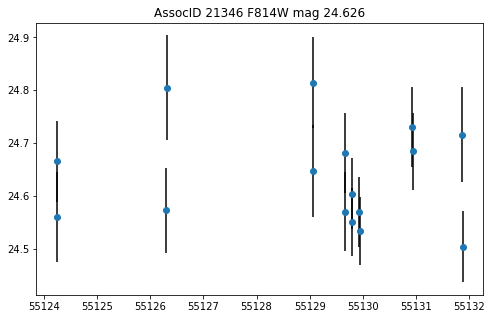

In [227]:
Analyzer.inspect(21346, 'F814W')

In [220]:
b=Analyzer.get_mad_mag_nom()

In [225]:
b[b.index.get_level_values(1)=='F555W'].sort_values(by='MAD')

,,MAG,MAD,Nmeas,MADSigma
AssocID,Filter,,,,
10614.0,F555W,23.03800,0.000000,3,0.000000
18216.0,F555W,24.46250,0.001500,3,0.020101
4666.0,F555W,21.30725,0.001625,16,0.069892
19201.0,F555W,25.24500,0.002250,3,0.025862
16935.0,F555W,24.87875,0.002250,4,0.030151
...,...,...,...,...,...
20334.0,F555W,25.33325,0.222500,5,2.557471
19846.0,F555W,25.51400,0.223750,7,2.571839
21346.0,F555W,25.76700,0.249500,11,NaN


In [131]:
df = pd.DataFrame({'X' : all_stars[all_stars['eha_2'] < 0.15]['v_1'] - all_stars[all_stars['eha_2'] < 0.15]['i_1'], 'Y' : all_stars[all_stars['eha_2'] < 0.15]['v_1'] - all_stars[all_stars['eha_2'] < 0.15]['ha_1']})  #we build a dataframe from the data
_, bins=pd.qcut(df.X,70, retbins=True)
data_cut = pd.cut(df.X,bins)           #we cut the data following the bins
grp = df.groupby(by = data_cut)        #we group the data by the cut

ret = grp.aggregate(np.median)         #we produce an aggregate representation (median) of each bin
#plt.scatter(df.X,df.Y,color='k',alpha=.2,s=2)
#plt.plot(ret.X,ret.Y,'r--',lw=4,alpha=.8)

fit = np.polyfit(ret.X,ret.Y, 4)
def running_median(VI_color):
    return np.poly1d(fit)(VI_color)

df= Analyzer.merge_color_maxha('F555W','F814W')

/home/luuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:272: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


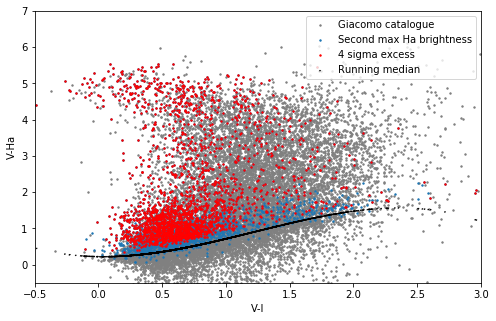

2150


In [160]:
plt.figure(figsize=(8,5))
plt.ylim(-0.5,7)
plt.xlim(-0.5,3)
five_sigma_excess = ((df.F555W-df.SecondMaxHa) - running_median(df.F555W-df.F814W))/np.sqrt((df.eColor**2+df.HaErr**2))>=5
#plt.scatter((Analyzer.MedMag.unstack()['F555W'] - Analyzer.MedMag.unstack()['F814W']),(Analyzer.MedMag.unstack()['F555W'] - Analyzer.MedMag.unstack()['F656N']), s=1, label='Median colors')
plt.scatter(all_stars['v_1']-all_stars['i_1'], all_stars['v_1']-all_stars['ha_1'], color='grey', s=2, label='Giacomo catalogue')
plt.scatter(df.F555W-df.F814W, df.F555W-df.SecondMaxHa, s=2, label='Second max Ha brightness')
plt.scatter((df.F555W-df.F814W)[five_sigma_excess], (df.F555W-df.SecondMaxHa)[five_sigma_excess], s=2, c='red', label='4 sigma excess')
plt.scatter(df.F555W-df.F814W,running_median(df.F555W-df.F814W), color='black', s=1, ls='dotted', label='Running median')

plt.xlabel('V-I')
plt.ylabel('V-Ha')
plt.legend(loc='best')
plt.show()
print(five_sigma_excess.sum())
ha_excess_stars = five_sigma_excess.index[five_sigma_excess].values

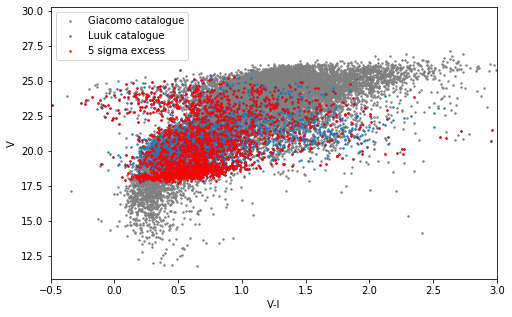

In [172]:
plt.figure(figsize=(8,5))
#plt.ylim(-0.5,7)
plt.xlim(-0.5,3)
plt.scatter(all_stars['v_1']-all_stars['i_1'], all_stars['v_1'], color='grey', s=2, label='Giacomo catalogue')
#plt.scatter(df.F555W-df.F814W, df.F555W-df.SecondMaxHa, s=2, label='Second max Ha brightness')
#plt.scatter((df.F555W-df.F814W)[five_sigma_excess], (df.F555W-df.SecondMaxHa)[five_sigma_excess], s=2, c='red', label='4 sigma excess')
#plt.scatter(df.F555W-df.F814W,running_median(df.F555W-df.F814W), color='black', s=1, ls='dotted', label='Running median')
plt.scatter((df.F555W-df.F814W), (df.F555W), s=2, label='Luuk catalogue')
plt.scatter((df.F555W-df.F814W)[five_sigma_excess], (df.F555W)[five_sigma_excess], s=2, c='red', label='5 sigma excess')


plt.xlabel('V-I')
plt.ylabel('V')
plt.legend(loc='best')
plt.show()

#print(five_sigma_excess.sum())
#ha_excess_stars = five_sigma_excess.index[five_sigma_excess].values

/home/luuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/luuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.


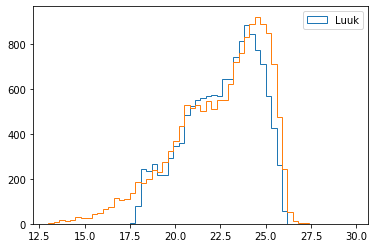

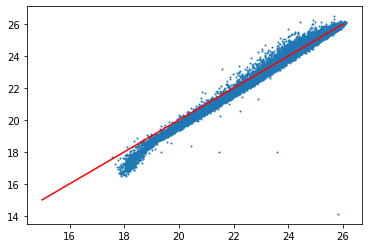

/home/luuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  from ipykernel import kernelapp as app
/home/luuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  app.launch_new_instance()


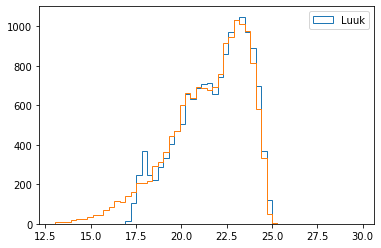

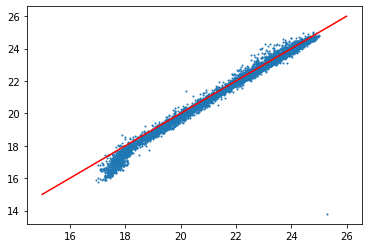

/home/luuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
/home/luuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


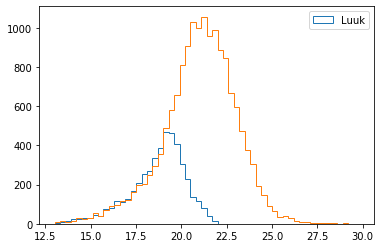

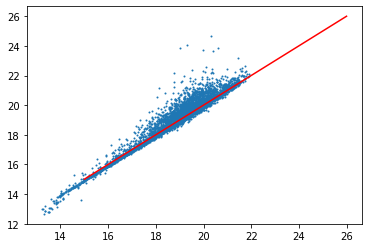

In [173]:
F555mags = Analyzer.GetMedMags()[Analyzer.GetMedMags().index.get_level_values(1)=='F555W'].droplevel(1)
merged = pd.merge(F555mags,all_stars['v_1'], left_index=True, right_index=True, how='outer')
plt.hist(merged['MAG'], histtype='step', normed=False, label='Luuk', bins=np.arange(13,30,0.3))
plt.hist(merged['v_1'], histtype='step', normed=False, bins=np.arange(13,30,0.3))
plt.legend()
plt.show()
plt.scatter(merged.dropna()['MAG'], merged.dropna()['v_1'], s=1)
plt.plot([15,26],[15,26], color='red')
plt.show()



F814Wmags = Analyzer.GetMedMags()[Analyzer.GetMedMags().index.get_level_values(1)=='F814W'].droplevel(1)
merged = pd.merge(F814Wmags,all_stars['i_1'], left_index=True, right_index=True, how='outer')
plt.hist(merged['MAG'], histtype='step', normed=False, label='Luuk', bins=np.arange(13,30,0.3))
plt.hist(merged['i_1'], histtype='step', normed=False, bins=np.arange(13,30,0.3))
plt.legend()
plt.show()
plt.scatter(merged.dropna()['MAG'], merged.dropna()['i_1'], s=1)
plt.plot([15,26],[15,26], color='red')
plt.show()
F656mags = Analyzer.GetMedMags()[Analyzer.GetMedMags().index.get_level_values(1)=='F656N'].droplevel(1)
merged = pd.merge(F656mags,all_stars['ha_1'], left_index=True, right_index=True, how='outer')
plt.hist(merged['MAG'], histtype='step', normed=False, label='Luuk', bins=np.arange(13,30,0.3))
plt.hist(merged['ha_1'], histtype='step', normed=False, bins=np.arange(13,30,0.3))
plt.legend()
plt.show()
plt.scatter(merged.dropna()['MAG'], merged.dropna()['ha_1'], s=1)
plt.plot([15,26],[15,26], color='red')
plt.show()

In [174]:
data = Analyzer.get_max_ha().dropna()
MaxMin = data.MinHa - data.MaxHa
MaxMin2 = data.SecondMinHa - data.MaxHa
Max2Min = data.MinHa - data.SecondMaxHa
Max2Min2 = data.SecondMinHa - data.SecondMaxHa

2150
2347
2150
2347


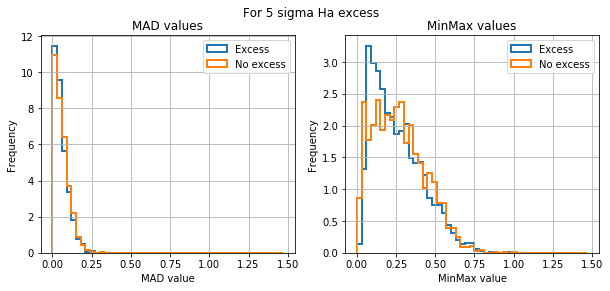

In [175]:
plt.figure(figsize=(10,4))
mads = Analyzer.GetMADvalues()
mads=mads[mads.index.get_level_values(1)=='F656N']
excess_mad = mads.loc[ha_excess_stars]
print(len(excess_mad))

not_pms = np.setdiff1d(mads.reset_index().AssocID, pms_stars.index.values)
not_pms = np.setdiff1d(not_pms, ha_excess_stars)
not_excess_mad = mads.loc[not_pms]

print(len(not_excess_mad))
plt.subplot(121)
excess_mad.hist(bins=np.arange(0,1.5,0.03), histtype='step', label='Excess', normed=True, linewidth=2)
not_excess_mad.hist(bins=np.arange(0,1.5,0.03), histtype='step', label='No excess', normed=True, linewidth=2)
plt.title('MAD values')

plt.suptitle('For 5 sigma Ha excess')
plt.legend()
plt.xlabel('MAD value')
plt.ylabel('Frequency')

plt.subplot(122)
plt.title('MinMax values')
minmax = Analyzer.GetMinMaxvalues()
minmax=minmax[minmax.index.get_level_values(1)=='F656N']
excess_minmax = minmax.loc[ha_excess_stars]
print(len(excess_mad))
not_pms = np.setdiff1d(minmax.reset_index().AssocID, pms_stars.index.values)
not_pms = np.setdiff1d(not_pms, ha_excess_stars)
not_excess_minmax = minmax.loc[not_pms]
print(len(not_excess_mad))

excess_minmax.hist(bins=np.arange(0,1.5,0.03), histtype='step', label='Excess', normed=True, linewidth=2)
not_excess_minmax.hist(bins=np.arange(0,1.5,0.03), histtype='step', label='No excess', normed=True, linewidth=2)
plt.legend()
plt.xlabel('MinMax value')
plt.ylabel('Frequency')
plt.savefig('5sigma_excess_mad_minmax.png', dpi=500)
plt.show()

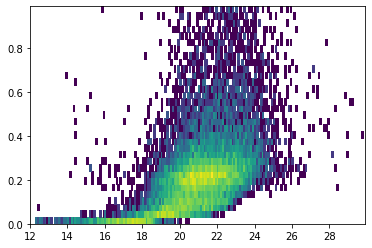

In [176]:
from matplotlib.colors import LogNorm
plt.hist2d(all_stars['ha_1'], all_stars['eha_2'], bins=(np.arange(12, 30, 0.1), np.arange(0,1,0.03)), norm=LogNorm())
plt.show()

In [177]:
all_stars[(all_stars['eha_2']>0.4)&(all_stars['eha_2']<0.8)].sort_values(by='ha_1')

,x,y,RA,Dec,u_1,eu_2,b_1,eb_2,v_1,ev_2,i_1,ei_2,ha_1,eha_2
ID,,,,,,,,,,,,,,
65,3929.362,1956.681,84.649650,-69.084343,13.334,0.177,14.566,-99.000,14.373,0.370,14.016,1.301,13.982,0.665
89,3024.050,2587.028,84.677128,-69.077518,13.515,0.327,14.823,0.324,14.703,0.150,14.437,0.577,14.391,0.525
81,3955.122,3845.331,84.648906,-69.063881,13.163,0.217,14.620,1.231,14.616,0.303,14.534,-99.000,14.408,0.461
91,3094.671,3061.830,84.674989,-69.072373,13.444,0.324,14.801,0.728,14.715,0.407,14.535,-99.000,14.444,0.415
109,4155.872,3001.118,84.642800,-69.073025,13.616,0.291,14.905,-99.000,14.811,0.213,14.395,0.714,14.455,0.637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17693,2684.068,2427.627,84.687442,-69.079245,26.560,0.116,25.792,0.052,25.045,0.037,23.768,0.022,28.397,0.529
21105,2459.567,2598.562,84.694253,-69.077393,-99.000,-99.000,26.996,0.132,25.837,0.047,23.896,0.021,28.843,0.570
8451,4037.173,4061.985,84.646423,-69.061533,23.697,0.075,23.485,0.029,22.830,0.035,21.596,0.023,28.922,0.406


In [189]:
df['MinMax'] = df['MinHa'] - df['MaxHa']

In [190]:
b=pd.merge(df, all_stars[['ha_1', 'eha_2']], left_on='AssocID', right_index=True).sort_values('eha_2')
b[b.ha_1<17.5].sort_values(by='MinMax').tail(20)

,Color,eColor,MaxHa,SecondMaxHa,MinHa,SecondMinHa,MedHa,HaErr,F555W,F814W,MinMax,ha_1,eha_2
AssocID,,,,,,,,,,,,,
885.0,0.727625,0.003606,17.42400,17.55300,17.69800,17.60500,17.577500,0.0230,18.537500,17.809875,0.27400,17.477,0.014
4152.0,0.186375,0.059908,17.23075,17.37300,17.50600,17.46975,17.427000,0.1580,20.816250,20.629875,0.27525,17.293,0.236
818.0,0.486500,0.005000,17.31200,17.37500,17.58800,17.53250,17.476625,0.0905,18.440500,17.954000,0.27600,17.393,0.063
677.0,0.286375,0.243591,17.09250,17.17400,17.37150,17.35850,17.293000,0.1125,18.335875,18.049500,0.27900,17.185,0.056
704.0,0.539500,0.005000,17.08300,17.16700,17.36300,17.35100,17.301750,0.0185,18.231625,17.692125,0.28000,17.023,0.009
728.0,0.703125,0.004472,17.28300,17.33200,17.56350,17.51300,17.407750,0.0780,18.350250,17.647125,0.28050,17.259,0.044
531.0,0.363000,0.005000,16.71250,16.74200,16.99700,16.89550,16.851875,0.0120,17.840500,17.477500,0.28450,16.715,0.155
1322.0,1.041625,0.073682,16.07600,16.26300,16.36950,16.35375,16.313625,0.0150,18.665250,17.623625,0.29350,16.260,0.019
1461.0,1.092500,0.005831,17.25825,17.29150,17.55500,17.54700,17.386250,0.0650,19.167125,18.074625,0.29675,17.269,0.041


84.6551954 -69.067981
./WFC2_crcleaned/ib6wd1rrq_crclean_wfc2.fits    1248.349    791.183
./WFC2_crcleaned/ib6wd4kvq_crclean_wfc2.fits    1249.844    835.007
./WFC2_crcleaned/ib6wd2btq_crclean_wfc2.fits    1242.133    791.887
./WFC2_crcleaned/ib6wd3fdq_crclean_wfc2.fits    1255.107    833.26
./WFC2_crcleaned/ib6wd5gdq_crclean_wfc2.fits    1252.452    791.965
./WFC2_crcleaned/ib6wd7hdq_crclean_wfc2.fits    1260.195    834.389
./WFC2_crcleaned/ib6wd6e9q_crclean_wfc2.fits    1258.304    789.375
./WFC2_crcleaned/ib6wr8jhq_crclean_wfc2.fits    1265.468    831.831


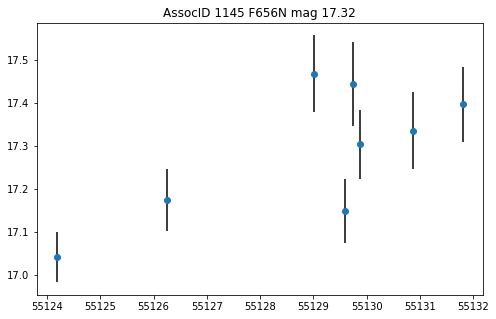

In [192]:
Analyzer.inspect(1145, 'F656N')

(0, 1)

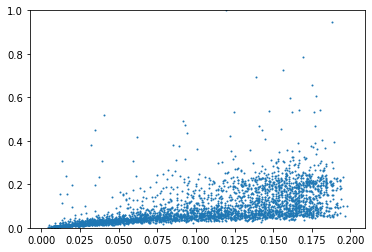

In [142]:
plt.scatter(b['HaErr'], b['eha_2'], s=1)
plt.ylim(0,1)

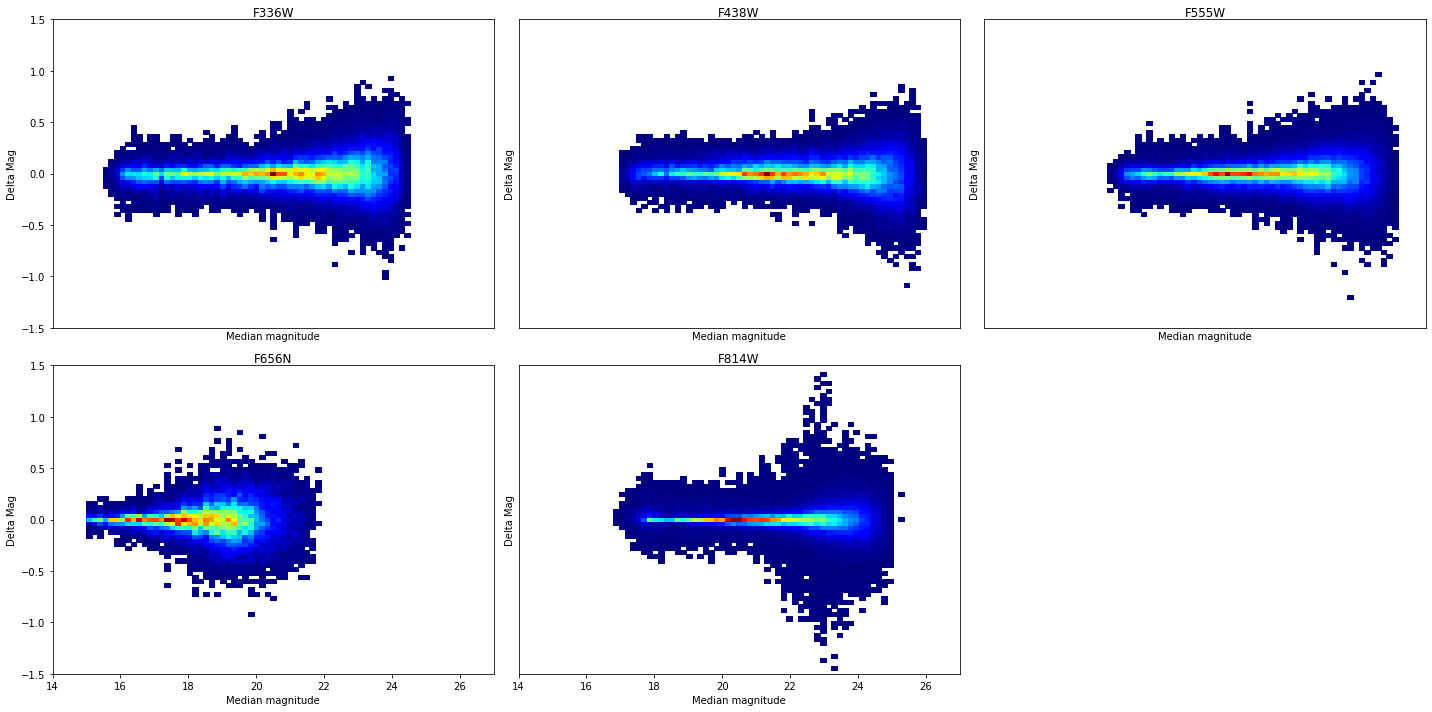

In [253]:
Analyzer.DrawTrumpets()

In [195]:
sex_phot_df = pd.read_pickle('../SExtractor/Analysis/MZPCleanedPhot_whitelightregrid.pickle')

In [196]:
sex_iraf = pd.DataFrame(sex_phot_df['MAG_APER2']).join(phot_df.MAG, how='inner')

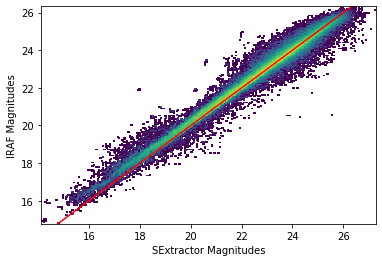

In [197]:
plt.hist2d(sex_iraf.MAG_APER2, sex_iraf.MAG,bins=250, norm=LogNorm())
plt.plot([14,27],[14,27], color='red')
plt.xlabel('SExtractor Magnitudes')
plt.ylabel('IRAF Magnitudes')
plt.show()

In [235]:
pd.DataFrame(Analyzer.GetMADvalues())

,,MAG
AssocID,Filter,
16.0,F656N,0.010000
18.0,F656N,0.026375
19.0,F656N,0.019000
20.0,F656N,0.022000
21.0,F656N,0.016500
...,...,...
22123.0,F814W,0.073000
22127.0,F814W,0.092000
22133.0,F814W,0.229250


In [249]:
a=pd.merge(Analyzer.GetMADvalues(), all_stars[['RA', 'Dec']], left_on='AssocID', right_index=True)

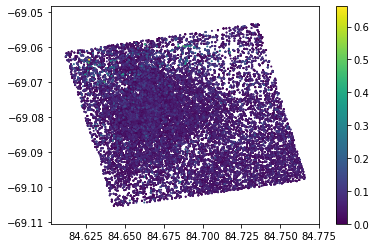

In [250]:
plt.scatter(a.RA, a.Dec, c=a.MAG, s=1)
plt.colorbar()

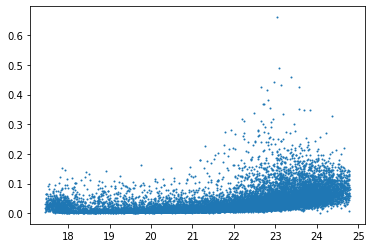

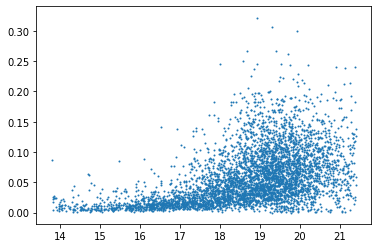

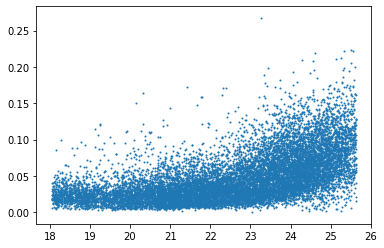

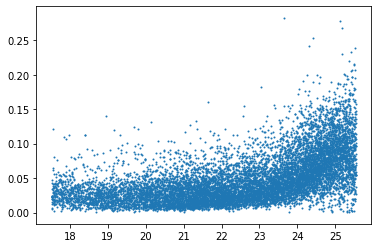

In [252]:
a=Analyzer.median_mad_sigma()
a=a[a.index.get_level_values(1)=='F814W']
plt.scatter(a.MAG, (a.MAD), s=1)
plt.show()

a=Analyzer.median_mad_sigma()
a=a[a.index.get_level_values(1)=='F656N']
plt.scatter(a.MAG, (a.MAD), s=1)
plt.show()

a=Analyzer.median_mad_sigma()
a=a[a.index.get_level_values(1)=='F555W']
plt.scatter(a.MAG, (a.MAD), s=1)
plt.show()

a=Analyzer.median_mad_sigma()
a=a[a.index.get_level_values(1)=='F438W']
plt.scatter(a.MAG, (a.MAD), s=1)
plt.show()